# Cutting Cloud Costs with Infrastructure Automation (Part I - AWS Infrastructure Automation)
## Review
2 posts ago, we discussed the concept of cloud and how cheap cloud could be by looking at a very specific use case of the compute-optimized p2.xlarge EC2 instance. I determined that, at a spot-price cost of \$0.17 and an incompetency of having to run the instance for 5 hours to train my model, I'd still be spending less than a dollar. I started thinking about how I could continue cutting costs to _**ensure**_ that I wouldn't be spending more than a few cents every time I need to train a model. If I'm looking at a dollar, that could still quickly add up if I somehow end up having to spin up an instance every day. At a dollar a day, that's still \$365 that could go towards something else... That could buy me 365 items from the dollar store!

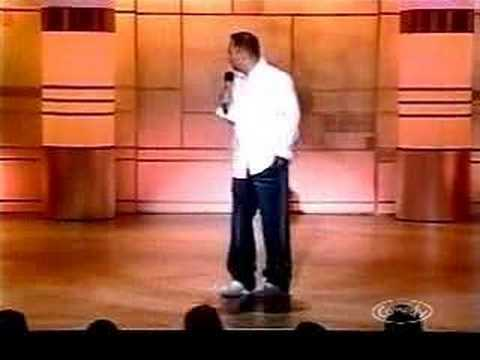

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('-qtrAMK7_Qk')

I don't mean to sound cheap or anything (in real life I'm actually really cheap, but I don't mean to sound cheap here), but it's just good business practice to think through a solution and find any points of weakness that might exist. This conversation might start with a dollar or two, but we have to consider the end-to-end process of exactly how this will work because, as soon as we spin up that EC2, we're on the clock. Thinking through the process, there is a lot we have to do to even start training the model...
1. Create a VPC with an internet gateway and default route so our application is accessible via public internet
2. Create default subnet so our EC2 can be assigned a public IPv4 address
3. Set default ACL and Security Group settings
4. Spin up EC2
5. Set up credentials
6. Install python, CUDA
7. Install common python libraries: pandas, matplotlib, numpy
8. Install domain-specific python libraries: tflearn, tensorflow, sklearn
9. Install additional tools: jupyter
10. Configure tensorflow to work with GPU
11. Import data into EC2
12. Write all code to ETL data
13. Write all code to train model
14. Save model / results

Man... that's a lot of steps right there. Is there a chance we can possibly automate some of this? The short answer from some previous experiences I've had and materials I've read is yes and yes.

Steps 1 - 5 essentially have to do with AWS, steps 6 - 10 have to do with setting up the virtual machine itself, and steps 11 - 14 are executing the code itself and training the model. There will be different ways to automate each batch of steps here, so let's go through each of these one by one over the next 3 posts. In this post, I will discuss AWS infrastructure automation (steps 1 - 5).

## AWS Infrastructure Automation - Terraform
Terraform is a way of capturing an entire AWS infrastructure in code. I was pretty blown away by the fact that this exists, because you can literally spin up an entire infrastructure in seconds. It almost feels like a cheat code, especially with some of the work experience I've had in the past working for the internet service provider.

To implement a route, you had to speak to multiple teams and open up various tickets and maybe wait up to 2-3 weeks for someone to work through a queue and get to your request. To add storage capacity to a server cluster, we might have had to work with the vendor to procure an additional hardware (where we'd have a vendor manager who negotiated a bulk rate), wait a few weeks for the hardware to arrive, have an entire lab team rack the server, cable it up to connect to the network, possibly have an implementation consultant come in and configure the server, and if the server ever breaks the consultant would have to come back and fix it or we'd order a new one and go through this entire process again. Accurate depiction of daily life below:

<img src="https://us.123rf.com/450wm/flairmicro/flairmicro1503/flairmicro150300669/38023860-frustrated-technician-working-in-server-room-of-data-center.jpg" alt="Drawing" style="width: 400px;"/>

This is obviously an oversimplification of the topic, and there are reasons why the service provider would not be able to use AWS, but maybe it's more of a commentary on the stuff I like to do that gets me going. There are folks who specialize in hardware and there are good reasons why you'd want your own dedicated hardware... For a service provider, they are literally the ones building out this infrastructure across the country so people across the country can have internet access, so they would never be building off AWS' network because, well, they _**are**_ the network for that region.

As a data scientist, our objective is to _**solve a business problem**_. Although this is melding quite a bit with technology, your traditional data scientist probably would like to stay as close to their objective and have as least distractions as possible. If we can automate the build of our infrastructure and networking, _**why wouldn't we**_?

Back to Terraform now... lol. Yes, Terraform lets us define our network and infrastructure in code, and run the code to spin up everything at once. You define your AWS infrastructure in a _**.tf**_ file using the _**HashiCorp Configuration Language (HCL)**_. A nice feature of Terraform is that changes are made incrementally, and this can be illustrated pretty simply by an example: Let's say we have a base infrastructure set up with a VPC, internet gateway, ACLs and Security Groups and we spin that up with one EC2... at some point, we'd probably want to add another EC2 right? We probably wouldn't want to tear the entire thing down and spin everything back up. The first EC2 could already be in production! If we run the same HCL script with the additional EC2 added, Terraform has the right context to say "everything in this configuration file already exists except for this second EC2, so I'm only going to act on this EC2 and leave everything else as it is".

So we talked a lot about all the different AWS components, but we haven't really tried to visualize it. The fact of the matter is, each EC2 has to live within a security group, which has to live within a VPC, which has to have a gateway, default routes, and ACLs. That's just all the default networking components we actually need to even get an EC2 online, so let's draw an extremely simple diagram as to what's happening here.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/32_aws_arch_diagram_1.png" alt="Drawing" style="width: 800px;"/>

Pretty simple, right? My laptop goes through the TELUS cloud and the Amazon cloud to eventually hit the internet gateway within my VPC. Then, within my VPC, I have ACLs and Security Groups which both (for now until I need more security) let any traffic in and out from any host and port to any other host and port. Since the EC2 is open to the public internet, I should be able to reach it via a public IPv4 address or DNS host name.

The Terraform HCL code that is used to generate this infrastructure can be found under the _**infrastructure**_ directory in this project's root. Let's tackle the sections of Terraform code:

### Initial Variables
~~~~
variable "myRegion" {
  type    = "string"
  default = "us-east-1"
}

variable "myCidrBlock" {
  type    = "string"
  default = "10.0.0.0/24"
}

variable "myKeyPair" {
  type    = "string"
  default = "ec2-user"
}
~~~~

It's useful to set some initial variables within Terraform, and it's quite nice that Terraform actually allows us to define variables to aid in the set up of our infrastructure. These variables can be used in the main code to define parameters of our AWS components. Here, I've only set 3 variables:
- The region we want to set up the infrastructure in (us-east-1 has the most services available to it, and we don't really care about region anyways because we're not dealing with any sensitive data per se, so why not go with AWS' flagship region for now)
- A /24 group of IPv4 addresses of the format 10.0.0.X, which will act as our subnet within our VPC
- The SSH key pair to use for our EC2, something that is already defined under AWS EC2 key pairs

### AWS Configuration
~~~~
provider "aws" {
    region = "${var.myRegion}"
}
~~~~

All we do here is set our region. Easy enough. I have already been working in us-east-1 through some previous projects I've done on AWS, so going forward, anything I do should be in us-east-1:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/33_aws_region.png" alt="Drawing" style="width: 300px;"/>

### VPC
~~~~
resource "aws_vpc" "main_vpc" {
    cidr_block = "${var.myCidrBlock}"
    instance_tenancy = "default"
    enable_dns_hostnames = true

    tags {
        Name = "main_vpc"
    }
}
~~~~

The first line of this code defines an AWS _**resource**_ of the type <em>**aws_vpc**</em> named <em>**main_vpc**</em>. This pattern is followed throughout for other resources as well.

The important parts here is that we're assigning our _**/24**_ block of IP addresses (256 IPs available) to the VPC and we're allowing elements in this VPC to have a public DNS hostname (Amazon will assign a random name to it).

After running the code, our VPC will be defined by these parameters, with other parameters being filled in with default values (for a project of this size and scope, we really don't need to get into too many details):

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/34_aws_vpc.png" alt="Drawing" style="width: 1000px;"/>

### Internet Gateway & Default Route Table
~~~~
resource "aws_internet_gateway" "main_vpc_igw" {
    vpc_id = "${aws_vpc.main_vpc.id}"

    tags {
        Name = "main_vpc_igw"
    }
}

resource "aws_default_route_table" "main_vpc_default_route_table" {
    default_route_table_id = "${aws_vpc.main_vpc.default_route_table_id}"

    route {
        cidr_block = "0.0.0.0/0"
        gateway_id = "${aws_internet_gateway.main_vpc_igw.id}"
    }

    tags {
        Name = "main_vpc_default_route_table"
    }
}

~~~~

This block is saying we want to assign an internet gateway to our VPC so we can send and receive traffic to the public internet, and add a route to the default route table saying traffic _**to and from any host**_ will be, by default, sent to the internet gateway to figure out and route. Simple!

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/35_aws_igw.png" alt="Drawing" style="width: 1000px;"/>

-----------

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/36_aws_default_route.png" alt="Drawing" style="width: 1000px;"/>

### Subnet
~~~~
resource "aws_subnet" "main_vpc_subnet" {
    vpc_id = "${aws_vpc.main_vpc.id}"
    cidr_block = "${var.myCidrBlock}"
    map_public_ip_on_launch = true

    tags {
        Name = "main_vpc_subnet"
    }
}
~~~~

In our subnet, we define the same IP block, but it's within the subnet that we define we want instances within this subnet to be assigned a _**public IP**_ as well. This will not be the 10.0.0.X IP that we assign because that's the _**private**_ IP referenced from within our VPC LAN, but the public IP will provide a routable IP address public hosts can reach as well.

In the screenshot below, AWS shows that our /24 block of IPs has 251 IPs. I was expecting 256 addresses, but perhaps AWS reserves some of these for standard processes. I'm not quite sure. Regardless, we won't be needing anywhere close to even 10 IPs, so we should be okay.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/37_aws_subnet.png" alt="Drawing" style="width: 1000px;"/>

### ACL & Security Groups
~~~~
resource "aws_default_network_acl" "main_vpc_nacl" {
    default_network_acl_id = "${aws_vpc.main_vpc.default_network_acl_id}"
    subnet_ids = ["${aws_subnet.main_vpc_subnet.id}"]

    ingress {
        protocol   = -1
        rule_no    = 1
        action     = "allow"
//        cidr_block = "${var.myIp}"
        cidr_block = "0.0.0.0/0"
        from_port  = 0
        to_port    = 0
    }

    egress {
        protocol   = -1
        rule_no    = 2
        action     = "allow"
        cidr_block = "0.0.0.0/0"
        from_port  = 0
        to_port    = 0
    }

    tags {
        Name = "main_vpc_nacl"
    }
}

resource "aws_default_security_group" "main_vpc_security_group" {
    vpc_id = "${aws_vpc.main_vpc.id}"

    ingress {
        protocol    = "-1"
//        cidr_blocks = ["${var.myIp}"]
        cidr_blocks = ["0.0.0.0/0"]
        from_port   = 0
        to_port     = 0
    }

    egress {
        protocol        = "-1"
        cidr_blocks     = ["0.0.0.0/0"]
        from_port       = 0
        to_port         = 0
    }

    tags {
        Name = "main_vpc_security_group"
    }
}
~~~~

I'm going to group these two together because they are basically both security measures that are saying the same thing. Keep in mind that the ACL is actually be implemented on the subnet within the VPC, and the Security Group is a set of rules one level deeper than the VPC, but for the purposes of our project, we're keeping security as a very low priority and we're just allowing any traffic from anywhere on any port.

Some details to note:
- A protocol of "-1" means "any protocol"
- An IP of 0.0.0.0/0 means "any IP"

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/38_aws_acl.png" alt="Drawing" style="width: 1000px;"/>

----------

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/39_aws_security_group.png" alt="Drawing" style="width: 1000px;"/>

### EC2 Spot Instance Request
~~~~
resource "aws_spot_instance_request" "aws_deep_learning_custom_spot" {
    ami           = "ami-45fdf753"
    spot_price    = "0.20"
    instance_type = "p2.xlarge"
    security_groups = ["${aws_default_security_group.main_vpc_security_group.id}"]
    subnet_id = "${aws_subnet.main_vpc_subnet.id}"
    key_name = "${var.myKeyPair}"

    tags {
        Name = "aws_deep_learning_custom_spot"
    }
}
~~~~

Our final piece. The EC2 spot instance! Simple enough here as well as Terraform makes the code pretty easily understandable. This spot request is referencing a specific _**AMI**_ (which I will go through in the next section) at a spot price of _**$0.20 / hr**_ with the instance type _**p2.xlarge**_ that we've already explored for GPU compute optimization. It will belong in the security group and subnets defined before and use the EC2 key-pair tied with the user _**ec2-user**_.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/40_aws_spot_request.png" alt="Drawing" style="width: 1000px;"/>

----------

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/41_aws_instance.png" alt="Drawing" style="width: 1000px;"/>

## Summary
At this point, we should have an up and running EC2 instance that is publically accessible by internet, but perhaps more importantly, we've built a infrastructure skeleton that we can now modify to easily implement various security measures as well! In the next post, I'll actually be diving into this EC2 to see how can set the instance up with all the tools we need.